In [2]:
# Preliminaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

# The Multi-tier framework for measuring energy access

This notebook analized the energy access data published by the 
[ESMAP Sector of the World Bank](https://mtfenergyaccess.esmap.org/country/rwanda), related to the energy access assessment
in Rwanda.

The assessment is based on the [Multi-Tier Framework](). In this approach, energy access is evaluated across a range of dimensions (called *attributes*). Along each attribute, each household is ranked in a 
**tier** (a level), from 0 (no access to energy) to 5 (full access to energy). The final energy access ranking
is then defined as the **minimum** over all attributed.

The report concerning the study in Rwanda can be downloaded [here](https://energydata.info/dataset/rwanda-multi-tier-framework-mtf-survey-2018)



## Structure of the Database

The questionnaire consists of ... Sections.

- Section A: (what is contained in Section A, what are the entries (households or something else, ...)

- Section B:

- Section C:

In [14]:
# read all the relevant data

# ...

# section I
section_I = pd.read_excel('../raw_data/complete_dataset.xlsx',sheet_name = "Section_I")
codebook_I = pd.read_excel('../references/codebook.xlsx', sheet_name= 'Section I')


In [67]:
# main dataset
main = pd.read_excel('../raw_data/complete_dataset.xlsx',sheet_name = "main_dataset")

## Description of the sample

Before starting the tier computation, we extract some general information about the sample (residential area, type of electricity/cooking solution used, etc.)


### Type of habitat

The question related to the habitat is in the main dataset (**B5**: "What is the type of habitat?"). Answers 1-3 are considered **rural**, answers 4-6 are considered **urban**.

In [ ]:
# add image
#Image("rural_urban.png")

In [74]:
# We add a new column to the main dataset, with values 'urban','rural', or 'other'
habitat_question = "B5_What is the type of habitat"
habitat = []
for index,row in main.iterrows():
    if row[habitat_question]==4 or row[habitat_question]==5 or row[habitat_question]==6:
        habitat.append('urban')
    elif row[habitat_question]==1 or row[habitat_question]==2 or row[habitat_question]==3:
        habitat.append('rural')
    else:
        habitat.append('other')
        
main['habitat'] = habitat



## Access to modern cooking solutions

... some intro about attributes ....

### Health and Safety 


In the case of Rwanda, three different categories are considered:
- Major injury (death, permanent health damage, burns/fire/poisoning, severe cough or respiratory problem)
- Minor injury (e.g., watery eyes)
- No accidents

Households where major injury has occurred are ranked in **Tier 3**, otherwise in **Tier 5**.

The question for the evaluation of the Tier is **I31**: "In the last 12 months, what type of harm/injury did your household face from this cookstove?"

**Remark**[Naomi] In the report, it seems that the World consideres only injuries from the **primary** cookstove. One should check how to get this out of the data


In [15]:
# figure missing
# Image("cooking_injuries.png")

There are therefore 8 options for this (multiple choice) question, which are coded as I31_1, ...,I31_8 in the database. Let us create a list of labels for this.

In [26]:
safety_questions_code = ['I31_'+str(k) for k in range(1,9)]


In [31]:
# Note: we can get the total number of answers per categoty from the 'codebook'
choices_id = []
choices_count = []
choices_label = []
for index,row in codebook_I.iterrows():
    if 'I31' in row['Variable']:
        choices_id.append(int(row['Variable'].replace('I31_','')))
        choices_count.append(row['Obs'])
        choices_label.append(row['Label'].replace(row['Variable']+'_',''))

total = sum(choices_count)
print("Statistics according to cookstoves ")
for l in range(0,len(choices_label)):
    print(choices_label[l]," = ",choices_count[l]," (", round(choices_count[l]/total*100,2),"%)")



Statistics according to cookstoves 
Death or permanent damage  =  1  ( 0.03 %)
Burns/fire/poisoning  =  45  ( 1.24 %)
Severe cough/respiratory problem  =  29  ( 0.8 %)
Other major injury  =  8  ( 0.22 %)
Minor injury  =  78  ( 2.14 %)
Fire with no injury  =  25  ( 0.69 %)
Itchy/watery eyes  =  5  ( 0.14 %)
None  =  3447  ( 94.75 %)


**Remark**: To get the data **per household** we have to go throught the database using the HHID key

In [138]:
# Check the number of household
n_household = len(np.unique(section_I["HHID"]))
section_I_HHID = section_I.groupby(['HHID']).sum()

# Let's add the type of habitat to the section I so we can separate according to rural/Urban info. 
injuries_df = pd.DataFrame.from_dict({'habitat':main['habitat'],'HHID': np.unique(section_I["HHID"])})
for i in safety_questions_code:
    injuries_df[i] = np.array(section_I_HHID[i])


In [148]:
def get_multiple_choice_values(df,questions):
    values = []
    for i in questions:
        values.append(sum(df[i]>0))

    # We return a dictionary with the count per injury type
    return {
        'major_accident': 100*(values[0]+values[1]+values[2]+values[3])/len(df),
        'minor_accident': 100*(values[4]+values[5]+values[6])/len(df),
        'no_accident': 100*(values[7])/len(df)
    }

# now we can calculate the results for total sample, urban and rural habitat using the same function
total_injuries = get_multiple_choice_values(injuries_df,safety_questions_code)
urban_injuries = get_multiple_choice_values(injuries_df.loc[injuries_df['habitat']=='urban'],safety_questions_code)
rural_injuries = get_multiple_choice_values(injuries_df.loc[injuries_df['habitat']=='rural'],safety_questions_code)

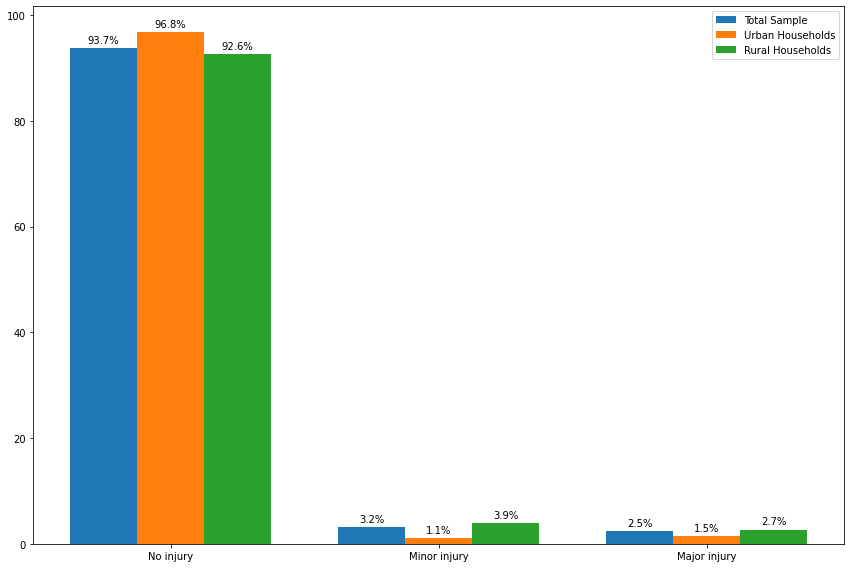

In [154]:
# grouped bar chart
labels = ['No injury','Minor injury','Major injury']

total_count = [total_injuries['no_accident'],total_injuries['minor_accident'],total_injuries['major_accident']]
urban_count = [urban_injuries['no_accident'],urban_injuries['minor_accident'],urban_injuries['major_accident']]
rural_count = [rural_injuries['no_accident'],rural_injuries['minor_accident'],rural_injuries['major_accident']]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width, total_count, width, label='Total Sample')
rects2 = ax.bar(x, urban_count, width, label='Urban Households')
rects3 = ax.bar(x + width, rural_count, width, label='Rural Households')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

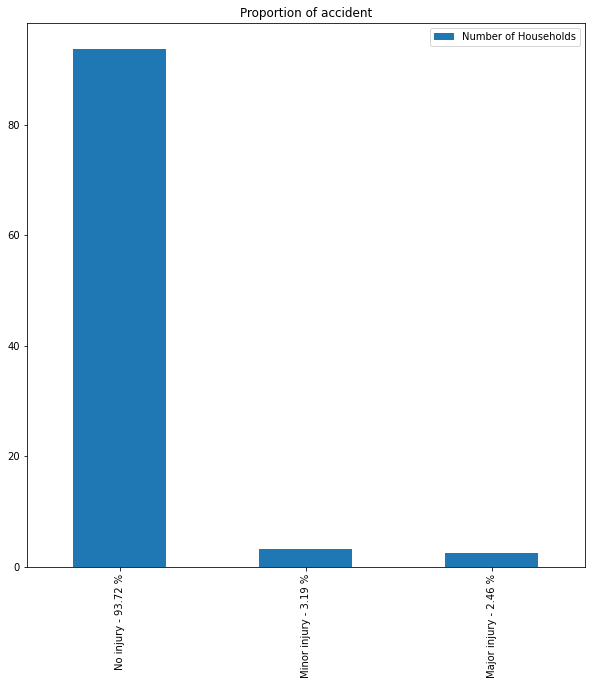

In [95]:
percent = [100*no_accident/n_household, 100*minor_accident/n_household, 100*major_accident/n_household] 

pie_ = pd.DataFrame({'Number of Households': percent},
                  index = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(index, percent)])

pie_.plot.bar(y ='Number of Households', figsize=(10, 10), title = 'Proportion of accident')


### Results 
- 2.5% of households are ranked in Safety Tier 3 (in the Rwanda Report: 2.2%)
- 97.5% of households are ranked in Safety Tier 5

#### Per Habitat:
- MTF urban Tier 3 : 1.2% - here: 1.48%
- MTF rural Tier 3 : 2.1% - here: 2.70%


____________________________________

# Safety of electricity

1- Electricity from National Grid 
C41
2- Electricity from Mini Grid 
C83
3- Electric geneator set
C112
4 - Rechargeable Battery 
C130
5- Pico-Hydro
C142
6- Solar device 
C175

Proportion of what they use. 

In [181]:
raw_data = pd.read_excel('complete_dataset.xlsx', sheet_name= 'main_dataset')

#data_C41_injuries = raw_data_C['C41_household member died or damaged because of electricity']


<AxesSubplot:title={'center':'Proportion of accident in urban areas'}>

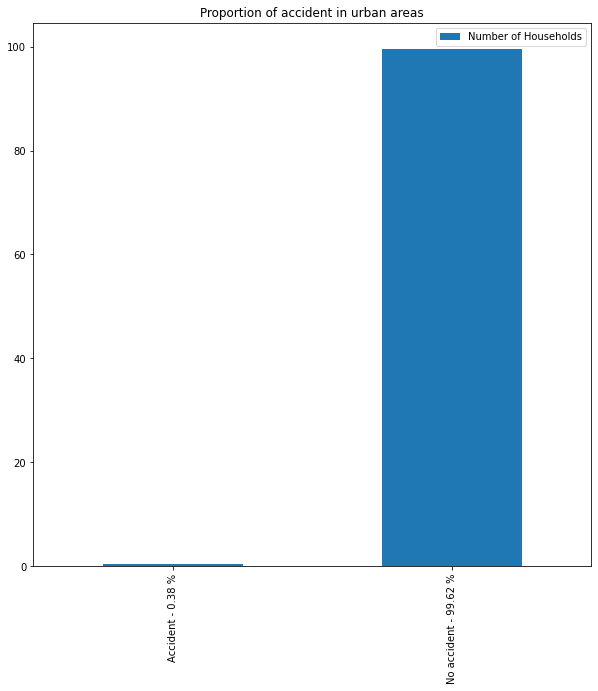

In [197]:
# 1- Electricity from National Grid C41
data_C41 = raw_data[['C41_household member died or damaged because of electricity']]
data_C41 = data_C41.dropna()
data_C41_injuries = data_C41[data_C41['C41_household member died or damaged because of electricity'] == 1.0]
data_C41_no_injuries = data_C41[data_C41['C41_household member died or damaged because of electricity'] == 2.0]


nb_injuries_C41 = len(data_C41_injuries)
nb_no_injuries_C41 = len(data_C41_no_injuries)
total = nb_injuries_C41 + nb_no_injuries_C41
 
injuries_C41_perc = 100*nb_injuries_C41/total
no_injuries_C41_perc = 100*nb_no_injuries_C41/total

percent = [injuries_C41_perc, no_injuries_C41_perc] 
index = ['Accident', 'No accident']
pie_ = pd.DataFrame({'Number of Households': percent},
                  index = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(index, percent)])

pie_.plot.bar(y ='Number of Households', figsize=(10, 10), title = 'Proportion of accident in urban areas')



In [206]:
data_C83 =raw_data[['C83_household members die or injured because of the grid electricity']]
data_C83 = data_C83.dropna()
data_C83_injuries = data_C83[data_C83['C83_household members die or injured because of the grid electricity'] == 1.0]
data_C83_no_injuries = data_C83[data_C83['C83_household members die or injured because of the grid electricity'] == 2.0]

nb_injuries_C83 = len(data_C83_injuries)
nb_no_injuries_C83 = len(data_C83_no_injuries)
total = nb_injuries_C83 + nb_no_injuries_C83
 
injuries_C83_perc = 100*nb_injuries_C83/total
no_injuries_C83_perc = 100*nb_no_injuries_C83/total

percent = [injuries_C83_perc, no_injuries_C83_perc]                                    

In [205]:
data_C112 = raw_data[['C112_household members died or injured because of the generator']]
data_C112 = data_C112.dropna()
data_C112_injuries = data_C112[data_C112['C112_household members died or injured because of the generator'] == 1.0]
data_C112_no_injuries = data_C112[data_C112['C112_household members died or injured because of the generator'] == 2.0]

nb_injuries_C112 = len(data_C112_injuries)
nb_no_injuries_C112 = len(data_C112_no_injuries)
total = nb_injuries_C112 + nb_no_injuries_C112
 
injuries_C112_perc = 100*nb_injuries_C112/total
no_injuries_C112_perc = 100*nb_no_injuries_C112/total

percent = [injuries_C112_perc, no_injuries_C112_perc] 
                                   

In [207]:
data_C130 = raw_data[['C130_household members died  injured because of the rechargeable batteries']]
data_C130 = data_C130.dropna()
data_C130

,C130_household members died injured because of the rechargeable batteries
101,2.0
2690,2.0
2897,2.0
3042,2.0


In [209]:
data_C142 = raw_data[['C142_household members died injured because of the pico-hydro system']]
data_C142 = data_C142.dropna()
data_C142



,C142_household members died injured because of the pico-hydro system
1493,2.0
2365,2.0
2366,2.0
2367,2.0
2370,2.0


In [213]:
data_C175 = raw_data[['C175_household members died or  injured because of the DEVICE']]
data_C175 = data_C175.dropna()


data_C175_injuries = data_C175[data_C175['C175_household members died or  injured because of the DEVICE'] == 1.0]
data_C175_no_injuries = data_C175[data_C175['C175_household members died or  injured because of the DEVICE'] == 2.0]

nb_injuries_C175 = len(data_C175_injuries)
nb_no_injuries_C175 = len(data_C175_no_injuries)
total = nb_injuries_C175 + nb_no_injuries_C175
 
injuries_C175_perc = 100*nb_injuries_C175/total
no_injuries_C175_perc = 100*nb_no_injuries_C175/total

percent = [injuries_C175_perc, no_injuries_C175_perc] 

print(percent)
data_C175
  

[0.0, 100.0]


,C175_household members died or injured because of the DEVICE
10,2.0
73,2.0
188,2.0
191,2.0
360,2.0
...,...
3148,2.0
3242,2.0
3252,2.0
3261,2.0


### Results/ Comments

The number of injuries here is of 0.38% et almost 0 for all the rest, which does ot correspond to the MTF survey, which has a %age of accidents of 4.7% Nationwide.